# **STEP 16.4:** Machine Learning Model #4 - Support Vector Machine

In [1]:
import pandas as pd
import random as np
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV, StratifiedKFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay, classification_report, roc_auc_score
from sklearn.svm import SVC 
from sklearn.metrics import log_loss
from sklearn.inspection import permutation_importance
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import learning_curve
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline


import warnings
warnings.filterwarnings("ignore")

### Isodose + ROI - Delta Radiomics + Clinical Features

In [2]:
absolute_data_isodose_roi = pd.read_csv("/notebooks/disk2/CSV_Dataset/07_RF_Treatment_Clinical.csv")

absolute_data_isodose_roi["Decision"] = (
    absolute_data_isodose_roi["Decision"]
    .replace({"2nd Treatment": 1})
)

absolute_data_isodose_roi["Decision"] = (
    absolute_data_isodose_roi["Decision"]
    .replace({"Follow-up": 0})
)

X = absolute_data_isodose_roi.drop(columns=['Patient ID', 'Mask Name','Decision', 'First Treatment', 'First Follow-Up'])
y = absolute_data_isodose_roi["Decision"]

categorical_cols = X.select_dtypes(include=["object"]).columns.tolist()

print("-------")
print(X.shape)
print(y.value_counts())
print("-------")

# OneHotEncoder
preprocessor = ColumnTransformer(
    transformers=[("cat", OneHotEncoder(handle_unknown="ignore"), categorical_cols)],
    remainder="passthrough"
)


X_encoded = preprocessor.fit_transform(X)

x_train, x_test, y_train, y_test = train_test_split(
    X_encoded, y, test_size=0.2, random_state=42, stratify=y
)

print("-------")
print(f"Training set: {x_train.shape}, Test set: {x_test.shape}\n")
print(f"Train Distribution:\n{pd.value_counts(y_train)}\n")
print(f"Test Distribution:\n{pd.value_counts(y_test)}")
print("-------")


-------
(177, 1326)
Decision
1    132
0     45
Name: count, dtype: int64
-------
-------
Training set: (141, 1339), Test set: (36, 1339)

Train Distribution:
Decision
1    105
0     36
Name: count, dtype: int64

Test Distribution:
Decision
1    27
0     9
Name: count, dtype: int64
-------


### Define best parameters

Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best Parameters: {'kernel': 'rbf', 'gamma': 'auto', 'class_weight': 'balanced', 'C': 10}
Best CV F1: 0.9551515151515151
Accuracy: 1.0
Classification Report (Train):
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        36
           1       1.00      1.00      1.00       105

    accuracy                           1.00       141
   macro avg       1.00      1.00      1.00       141
weighted avg       1.00      1.00      1.00       141

Confusion Matrix (Train):
 [[ 36   0]
 [  0 105]]


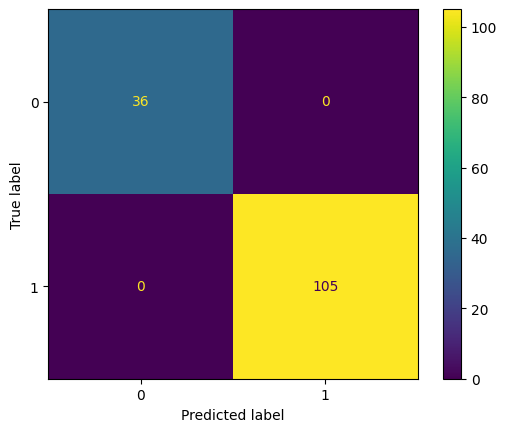

In [6]:
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('svm', SVC(probability=True, random_state=42))
])

param_dist = {
    'C': [0.1, 1, 10, 100, 1000],             
    'gamma': ['scale', 'auto', 0.01, 0.1],    
    'kernel': ['linear', 'rbf', 'poly'],     
    'class_weight': [None, 'balanced'],      
}

svm_clf = SVC(probability=True, random_state=42)
random_search = RandomizedSearchCV(
    estimator=svm_clf,
    param_distributions=param_dist,
    n_iter=20,                
    scoring='f1',
    cv=5,
    verbose=1,
    random_state=42,
    n_jobs=-1
)


random_search.fit(x_train, y_train)

print("Best Parameters:", random_search.best_params_)
print("Best CV F1:", random_search.best_score_)
y_pred = random_search.predict(x_train)

print("Accuracy:", accuracy_score(y_train, y_pred))
print("Classification Report (Train):\n", classification_report(y_train, y_pred))
print("Confusion Matrix (Train):\n", confusion_matrix(y_train, y_pred))

ConfusionMatrixDisplay.from_estimator(random_search, x_train, y_train)
plt.show()

Test Accuracy: 0.8611111111111112
Test Classification Report:
               precision    recall  f1-score   support

           0       0.83      0.56      0.67         9
           1       0.87      0.96      0.91        27

    accuracy                           0.86        36
   macro avg       0.85      0.76      0.79        36
weighted avg       0.86      0.86      0.85        36

Test Confusion Matrix:
 [[ 5  4]
 [ 1 26]]


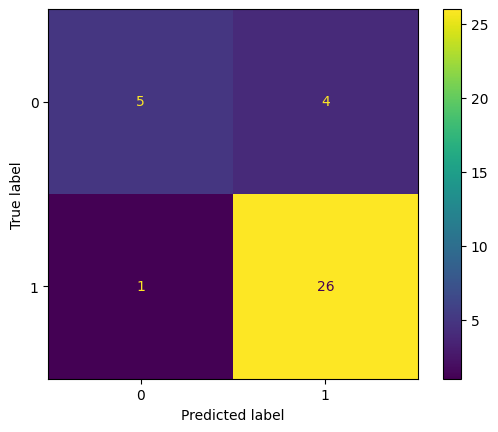

In [7]:
y_test_pred = random_search.predict(x_test)
print("Test Accuracy:", accuracy_score(y_test, y_test_pred))
print("Test Classification Report:\n", classification_report(y_test, y_test_pred))
print("Test Confusion Matrix:\n", confusion_matrix(y_test, y_test_pred))

ConfusionMatrixDisplay.from_estimator(random_search, x_test, y_test)
plt.show()

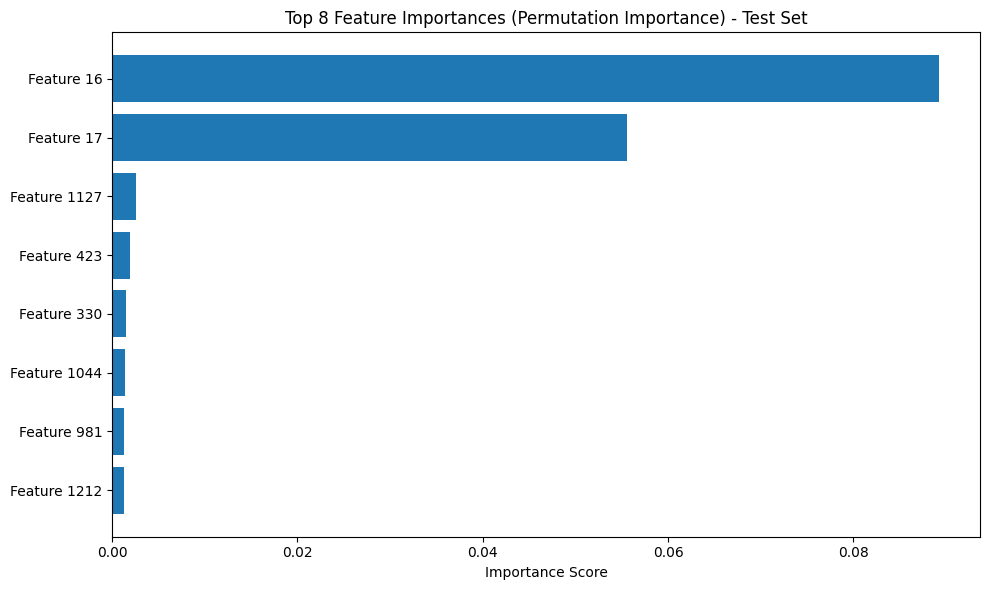

In [12]:
result = permutation_importance(
    random_search.best_estimator_,
    X=x_test, y=y_test,
    n_repeats=10,
    random_state=42,
    scoring="neg_log_loss"
)

sorted_idx = np.argsort(result.importances_mean)[::-1]
top_8_idx = sorted_idx[:8]
top_8_vals = result.importances_mean[top_8_idx]

if hasattr(x_test, 'columns'):
    feature_names = np.array(x_test.columns)
else:
    feature_names = np.array([f"Feature {i}" for i in range(x_test.shape[1])])

top_8_names = feature_names[top_8_idx]

plt.figure(figsize=(10, 6))
plt.title("Top 8 Feature Importances (Permutation Importance) - Test Set")
plt.barh(range(8), top_8_vals, align="center")
plt.yticks(range(8), top_8_names)
plt.gca().invert_yaxis()
plt.xlabel("Importance Score")
plt.tight_layout()
plt.show()